In [12]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.src.models import Sequential
from keras.src.layers import TimeDistributed, Conv1D, BatchNormalization, Flatten, LSTM, Dense, Dropout, Reshape
from keras.src.optimizers import Adam
from keras.src.callbacks import EarlyStopping

In [8]:
# ✅ 1️⃣ Load Dataset
data_dir = r"C://Users//visha//Downloads//emotion-recognition-using-speech-master//archive (3)"  # Update this path

# Check if the directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory not found: {data_dir}")

# Initialize lists
file_emotion = []
file_path = []

# ✅ 2️⃣ Read Audio Files & Extract Emotion Labels
for actor_folder in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor_folder)
    if not os.path.isdir(actor_path):
        continue  

    for file in os.listdir(actor_path):
        file_path_full = os.path.join(actor_path, file)
        if not os.path.isfile(file_path_full):
            continue

        file_parts = file.split('.')[0].split('-')  # Remove extension & split by '-'
        if len(file_parts) > 2:
            try:
                emotion = int(file_parts[2])  # Extract emotion
                file_emotion.append(emotion)
                file_path.append(file_path_full)
            except ValueError:
                print(f"Skipping invalid file: {file}")
        else:
            print(f"Skipping improperly formatted file: {file}")

# Create DataFrame
data_path = pd.DataFrame({"Emotions": file_emotion, "Path": file_path})

# ✅ 3️⃣ Map Emotion Labels Correctly
emotion_mapping = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}
data_path['Emotions'] = data_path['Emotions'].map(emotion_mapping)

print("Sample Data:\n", data_path.head())

Sample Data:
   Emotions                                               Path
0  neutral  C://Users//visha//Downloads//emotion-recogniti...
1  neutral  C://Users//visha//Downloads//emotion-recogniti...
2  neutral  C://Users//visha//Downloads//emotion-recogniti...
3  neutral  C://Users//visha//Downloads//emotion-recogniti...
4     calm  C://Users//visha//Downloads//emotion-recogniti...


In [4]:
import os
import pandas as pd

# ✅ Define dataset directory
data_dir = r"C://Users//visha//Downloads//emotion-recognition-using-speech-master//archive (3)"  # Update this path

# Check if directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Directory not found: {data_dir}")

# ✅ Initialize lists
file_emotion = []
file_path = []

# ✅ Correct Emotion Mapping Based on RAVDESS Labels
emotion_mapping = {
    1: "neutral", 2: "calm", 3: "happy", 4: "sad",
    5: "angry", 6: "fear", 7: "disgust", 8: "surprise"
}

# ✅ Extract emotion labels from filenames
for actor_folder in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor_folder)
    if not os.path.isdir(actor_path):
        continue  # Skip non-directory files

    for file in os.listdir(actor_path):
        file_path_full = os.path.join(actor_path, file)
        if not os.path.isfile(file_path_full):
            continue  # Skip non-audio files

        # ✅ Extract emotion number from filename
        file_parts = file.split('.')[0].split('-')  # Split filename by '-'
        if len(file_parts) > 2:
            try:
                emotion_num = int(file_parts[2])  # Extract 3rd element
                emotion_label = emotion_mapping.get(emotion_num, "unknown")  # Map to label
                file_emotion.append(emotion_label)
                file_path.append(file_path_full)
            except ValueError:
                print(f"Skipping invalid file: {file}")
        else:
            print(f"Skipping improperly formatted file: {file}")

# ✅ Create DataFrame
data_path = pd.DataFrame({"Emotion": file_emotion, "Path": file_path})

# ✅ Print Sample Data
print("🎯 Sample Data:\n", data_path.head())

# ✅ Save to CSV (Optional)
data_path.to_csv("ravdess_labeled_data.csv", index=False)
print("✅ Labeled data saved to 'ravdess_labeled_data.csv'")


🎯 Sample Data:
    Emotion                                               Path
0  neutral  C://Users//visha//Downloads//emotion-recogniti...
1  neutral  C://Users//visha//Downloads//emotion-recogniti...
2  neutral  C://Users//visha//Downloads//emotion-recogniti...
3  neutral  C://Users//visha//Downloads//emotion-recogniti...
4     calm  C://Users//visha//Downloads//emotion-recogniti...
✅ Labeled data saved to 'ravdess_labeled_data.csv'


In [9]:
# ✅ 4️⃣ Data Augmentation Functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def pitch(data, sampling_rate, pitch_factor=2):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# ✅ 5️⃣ Feature Extraction
def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=20)  # Extracting 20 MFCC features
    return mfcc

In [10]:
# Function to apply random transformations
def transform_audio(data, sample_rate, fns):
    fn = random.choice(fns)
    if fn == pitch:
        return fn(data, sample_rate)
    elif fn == "None":
        return data
    else:
        return fn(data)

In [13]:
# ✅ 6️⃣ Extract Features from Audio Files
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    fns = [noise, pitch, "None"]
    features = []
    for _ in range(3):  # Apply transformations 3 times for augmentation
        augmented_data = transform_audio(data, sample_rate, fns)
        extracted_features = extract_features(augmented_data, sample_rate)[:,:108]  # Limiting feature length
        features.append(extracted_features)

    for feature in features:
        if feature.shape == (20, 108):  # Ensure correct shape
            X.append(feature)
            Y.append(emotion)  # Append the corresponding emotion label

In [14]:
# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

print("Feature Extraction Completed! Shape of X:", X.shape)
print("Shape of Y before encoding:", Y.shape)

Feature Extraction Completed! Shape of X: (4275, 20, 108)
Shape of Y before encoding: (4275,)


In [15]:
# ✅ 7️⃣ One-Hot Encode Labels Correctly
encoder = OneHotEncoder(sparse_output=False)  # Ensure dense array
Y = encoder.fit_transform(Y.reshape(-1,1))

print("Shape of Y after one-hot encoding:", Y.shape) 

Shape of Y after one-hot encoding: (4275, 8)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)

# # ✅ 9️⃣ Fix Data Shape for cnn-LSTM
# x_train = np.expand_dims(x_train, axis=-1)  # Shape: (3420, 20, 108, 1)
# x_test = np.expand_dims(x_test, axis=-1)    # Shape: (855, 20, 108, 1)

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape: (3420, 20, 108) (3420, 8)
Test shape: (855, 20, 108) (855, 8)


MODELTRAINING-LSTM

In [ ]:

# ✅ 🔥 Pure LSTM Model 
model = Sequential()

# **LSTM Layers for Temporal Feature Learning**
model.add(LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4, input_shape=(20, 108)))  # 🔥 Increased LSTM units
model.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))  # 🔥 Second LSTM Layer

# **Fully Connected Layers**
model.add(Dense(64, activation='relu'))  
model.add(Dropout(0.4))  # 🔥 Increased dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # 🔥 Added dropout
model.add(Dense(8, activation='softmax'))  # 8 emotion classes

# ✅ 🔥 Compile Model
optimizer = Adam(learning_rate=0.0005)  # 🔥 Lower learning rate for better stability
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ 🔥 Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ✅ 🔥 Train the Model
history = model.fit(x_train.reshape(3420, 20, 108), y_train, batch_size=64, epochs=80, 
                    validation_data=(x_test.reshape(855, 20, 108), y_test), callbacks=[early_stopping])

# ✅ 🔥 Model Summary
model.summary()


c:\Users\visha\Downloads\emotion-recognition-using-speech-master\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.1361 - loss: 2.0765 - val_accuracy: 0.1591 - val_loss: 2.0480
Epoch 2/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.1266 - loss: 2.0696 - val_accuracy: 0.1661 - val_loss: 2.0389
Epoch 3/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.1641 - loss: 2.0517 - val_accuracy: 0.1825 - val_loss: 1.9936
Epoch 4/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.1819 - loss: 2.0252 - val_accuracy: 0.2327 - val_loss: 1.9460
Epoch 5/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1906 - loss: 2.0037 - val_accuracy: 0.2526 - val_loss: 1.9049
Epoch 6/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2095 - loss: 1.9830 - val_accuracy: 0.2643 - val_loss: 1.8674
Epoch 7/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2277 - loss: 1.9421 - val_accuracy: 0.2877 - val_loss: 1.8305
Epoch 8/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.2562 - loss: 1.9186 - val_accuracy: 0.2912 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │       121,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531,770 (2.03 MB)

 Trainable params: 177,256 (692.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 354,514 (1.35 MB)

BI-LSTM MODEL 


In [18]:
from keras.src.layers import Input, LSTM, Dense, Dropout, Bidirectional, Attention
from keras.src.optimizers import Adam
from keras.src.models import Model
from keras.src.callbacks import EarlyStopping

# Define input shape
inputs = Input(shape=(20, 108))

# 🔥 BiLSTM Layer
lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(inputs)

# 🔥 Attention Mechanism (Corrected)
attention = Attention()([lstm_out, lstm_out])  # Using proper query & key-value inputs

# 🔥 Second BiLSTM Layer
lstm_out = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(attention)

# 🔥 Fully Connected Layers
dense_out = Dense(128, activation='relu')(lstm_out)
dense_out = Dropout(0.4)(dense_out)
dense_out = Dense(64, activation='relu')(dense_out)
dense_out = Dropout(0.3)(dense_out)
outputs = Dense(8, activation='softmax')(dense_out)  # 8 emotion classes

# Build model
model = Model(inputs, outputs)

# Compile model
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    x_train, y_train,  # No need to reshape if already (3420, 20, 108)
    batch_size=64, epochs=100, 
    validation_data=(x_test, y_test), 
    callbacks=[early_stopping]
)

# Model Summary
model.summary()


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.1341 - loss: 2.0957 - val_accuracy: 0.2374 - val_loss: 2.0030
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2063 - loss: 2.0145 - val_accuracy: 0.2936 - val_loss: 1.8295
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2783 - loss: 1.8815 - val_accuracy: 0.3228 - val_loss: 1.7373
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.2930 - loss: 1.8216 - val_accuracy: 0.3345 - val_loss: 1.7050
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.3166 - loss: 1.7753 - val_accuracy: 0.3532 - val_loss: 1.6388
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.3438 - loss: 1.7246 - val_accuracy: 0.3895 - val_loss: 1.5916
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.3454 - loss: 1.7041 - val_accuracy: 0.3953 - val_loss: 1.5600
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.3684 - loss: 1.6332 - val_accuracy

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 108)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 256)   │    242,688 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ attention[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │        520 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,296,986 (4.95 MB)

 Trainable params: 432,328 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 864,658 (3.30 MB)

In [19]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x_test.reshape(855, 20, 108), y_test)

print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8104 - loss: 0.5589
✅ Test Accuracy: 81.64%
✅ Test Loss: 0.5392


In [20]:
import numpy as np

# Get model predictions
y_pred = model.predict(x_test.reshape(855, 20, 108))

# Convert predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step


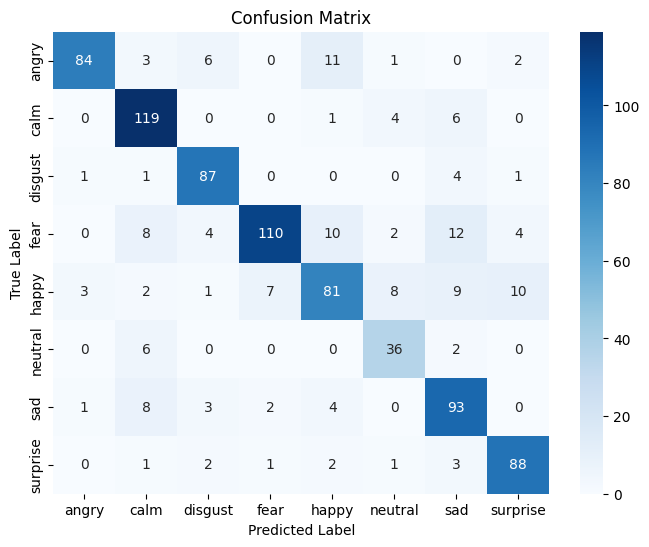

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [23]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=encoder.categories_[0]))

              precision    recall  f1-score   support

       angry       0.94      0.79      0.86       107
        calm       0.80      0.92      0.86       130
     disgust       0.84      0.93      0.88        94
        fear       0.92      0.73      0.81       150
       happy       0.74      0.67      0.70       121
     neutral       0.69      0.82      0.75        44
         sad       0.72      0.84      0.78       111
    surprise       0.84      0.90      0.87        98

    accuracy                           0.82       855
   macro avg       0.81      0.82      0.81       855
weighted avg       0.82      0.82      0.82       855



In [24]:
# Save the trained model
model.save("C://Users//visha//Downloads//emotion-recognition-using-speech-master//emotion-recognition-using-speech-master//MODELS//model_bi-lstm.keras")

print("✅ Model saved successfully!")

✅ Model saved successfully!


In [26]:

import tensorflow as tf
load_model = tf.keras.models.load_model  # ✅ Directly call TensorFlow's function
loaded_model = load_model("C://Users//visha//Downloads//emotion-recognition-using-speech-master//emotion-recognition-using-speech-master//MODELS//model_bi-lstm.keras")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!
